In [1]:
import os 
import numpy as np 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision.ops import MLP
from tqdm.notebook import trange

* Write a validation step
* Experiment with `MLP` options
* Implement a CNN

Data: D.shape=(50000, 29) Y.shape=(50000, 2)


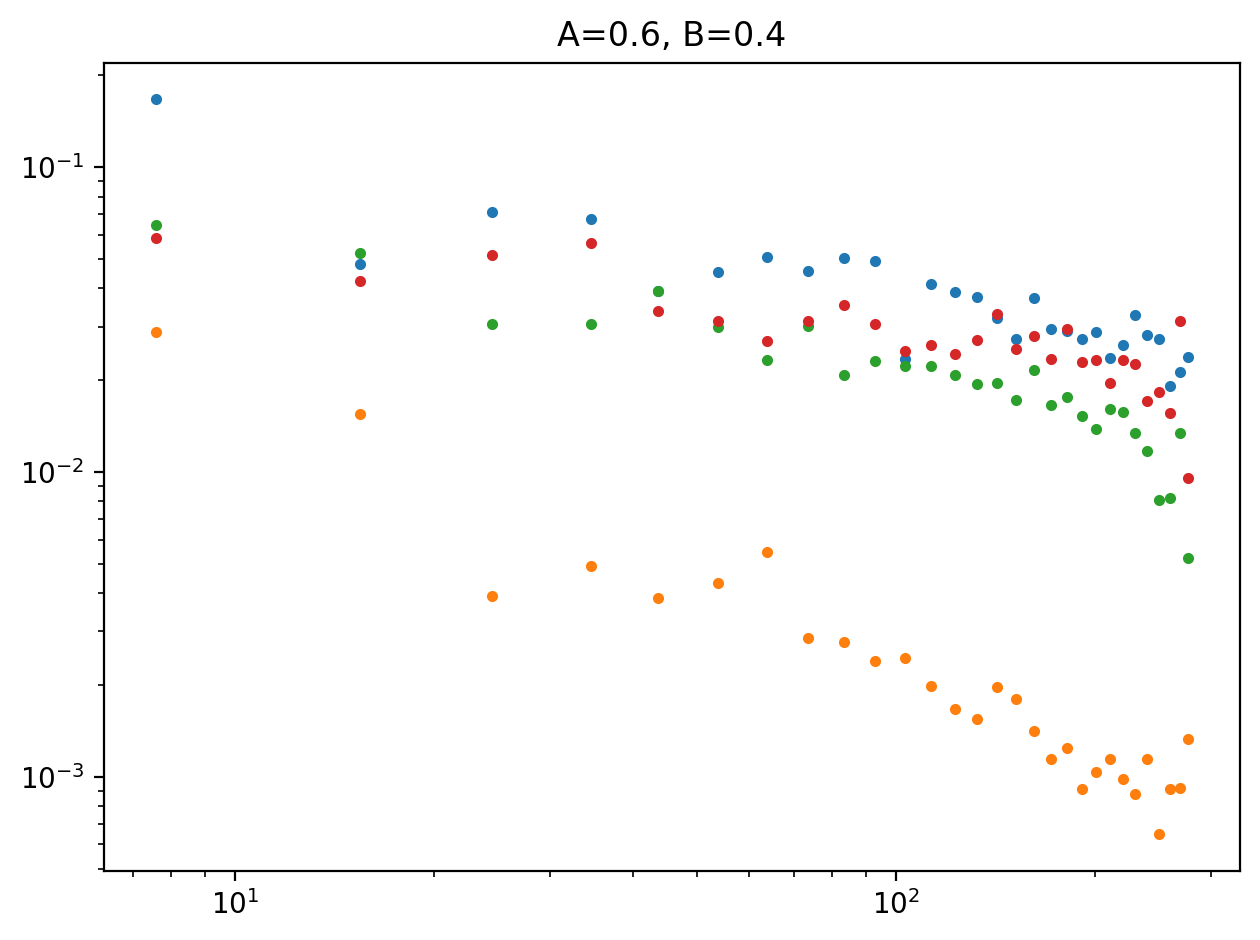

In [2]:
field_type = "gaussian" 
data_dir = "data/"

AB = np.array([1., 1.])
lower = np.array([0.1, .1])
upper = np.array([2., 2.])

D = np.load(data_dir + field_type + "_fields_Pk.npy")
Y = np.load(data_dir + field_type + "_fields_parameters.npy")

D0 = np.load(data_dir + field_type + "_fields_Pk_fiducial.npy")

covariance = np.load(data_dir + field_type + "_fields_Pk_covariance.npy") # NOT THE Pk COVARIANCE

print(f"Data: {D.shape=} {Y.shape=}")

k = np.load(data_dir + "k_values.npy")

fig, ax = plt.subplots(1, 1, dpi=200)
for i in range(4):
    A, B = Y[i]
    ax.set_title(f"{A=:.1f}, {B=:.1f}")
    ax.loglog(k, D[i], linestyle="", marker=".")
plt.tight_layout()
plt.show()

In [3]:
# a, b = D.min(), D.max()
# D = 2. * (D - a) / (b - a) - 1.
# D0 = 2. * (D0 - a) / (b - a) - 1.

In [4]:
# Data
data_dim = np.prod(D.shape[1:])
parameter_dim = Y.shape[-1]
# Model
H = [128, 128]
activation = nn.Tanh
# Optimisation
n_steps = 20_000
lr = 5e-4
batch_size = 400

# Experiment with args here
net = MLP(
    data_dim, 
    H + [parameter_dim], 
    activation_layer=activation,
    bias=True,
    dropout=0.
)

In [5]:
def convert(x):
    return torch.as_tensor(x).float()

def get_data(n):
    ix = np.random.randint(len(D), size=(n,))
    return convert(D[ix]).flatten(1), convert(Y[ix])

In [6]:
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

loss_fn = nn.MSELoss()

losses = []
with trange(n_steps) as steps:
    for s in steps:
        x, y = get_data(batch_size)

        loss = loss_fn(net(x), y)
        
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()

        losses += [loss.item()]
        steps.set_postfix(loss=f"{loss:.3E}")

  0%|          | 0/20000 [00:00<?, ?it/s]

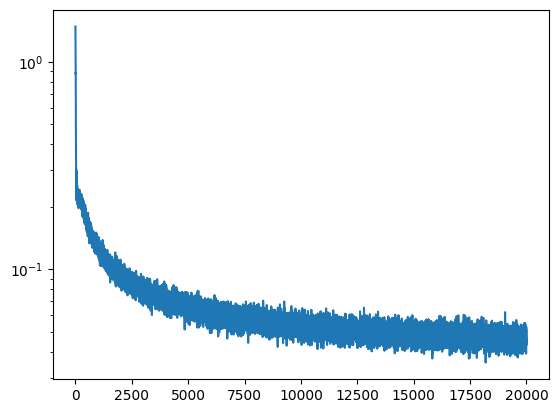

In [7]:
plt.semilogy(losses)
plt.show()

In [8]:
mean = D0.mean(axis=0).flatten()

data = np.random.multivariate_normal(mean, covariance)

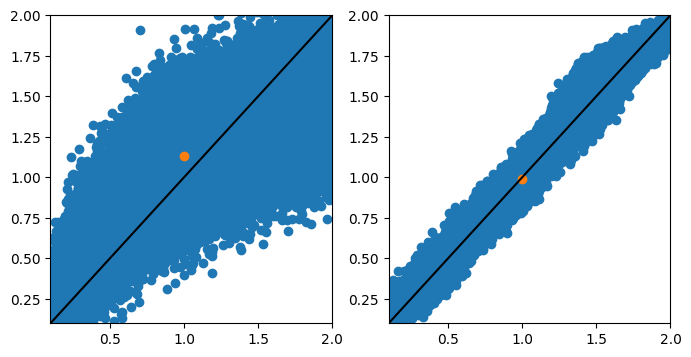

In [13]:
net = net.eval()

def apply_net(x):
    # Convert a numpy array to a tensor and detach it
    return net(convert(x).flatten(1)).detach().numpy()

Y_data = apply_net(data[None, :]) 
Y_mean = apply_net(mean[None, :])
Y_ = apply_net(D)

fig, axs = plt.subplots(1, 2, figsize=(8., 4.))

ax = axs[0]
ax.scatter(Y[:, 0], Y_[:, 0])
ax.scatter(AB[0], Y_mean[:, 0])

ax.set_xlim(lower[0], upper[0])
ax.set_ylim(lower[0], upper[0])
ax.axline((0, 0), slope=1, color="k")

ax = axs[1]
ax.scatter(Y[:, 1], Y_[:, 1])
ax.scatter(AB[1], Y_mean[:, 1])

ax.set_xlim(lower[1], upper[1])
ax.set_ylim(lower[1], upper[1])
ax.axline((0, 0), slope=1, color="k")

plt.show()

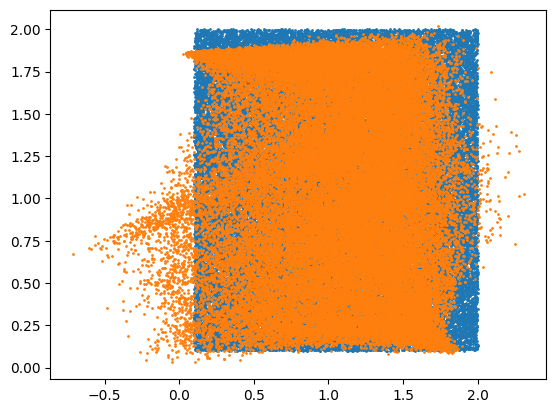

In [14]:
plt.figure()
plt.scatter(*Y.T, s=1.)
plt.scatter(*Y_.T, s=1.)
# plt.scatter(*Y__.T, s=1.)
plt.show()

In [15]:
print(Y_.shape)
print(Y.shape)

(50000, 2)
(50000, 2)


In [17]:
# Save output summaries for simulations + data
np.save(os.path.join(data_dir, field_type + "_nn_summary_mean_Pk.npy"), Y_mean)
np.save(os.path.join(data_dir, field_type + "_nn_summary_data_Pk.npy"), Y_data)
np.save(os.path.join(data_dir, field_type + "_nn_summaries_Pk.npy"), Y_)